# Week 4 Inroduction
### Date: 28 Oct 2021

Last week you learned about different methods for segmenting an image into regions of interest and coding some algorithms. In this session you will get some more experience coding image segmentation algorithms. 

**Your task:** To choose one of the two algorithms *Region growing* or *Connected components* and impelemnt it to get image segmentation.
We encourage you to compare your impelemntations with each other specially if the other person is impelemnting a different algorithm than youeself.


In [10]:
import numpy as np
import copy
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import random
from PIL import Image
#to visualize the plots within the notebook
%matplotlib inline

## Region growing
Region growing is a simple way to segment a region of interest from the background of an image.
It produces a binary image as output, where a value of 1 represents the region of interest and a value of 0 represents the background.

The algorithm is:
1. Start from a seed pixel.
2. Add neighbouring pixels that satisfy the criteria defining a region (e.g. similar intensity values, intensity above a threshold).
3. Repeat until we can include no more pixels.

Your task is to write a function in Matlab that implements the region growing algorithm.
Something like:
```
  segmented_img = region_growing(img, x, y)
```

* img: the image to be segmented
* x: the x-coordinate of the seed pixel
* y: the y-coordinate of the seed pixel
* segmented_img: the binary image output of region growing

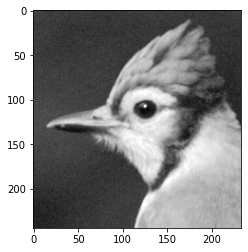

In [11]:
img = cv2.imread('../images/sample_image.jpg')

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # replace this code and load your image

# display the image
# display(gray_img)
plt.imshow(gray_img, 'gray')

In [12]:
def regionGrow(img, seeds, thresh, p = 1):
    '''
    Impelemnt region growing algorithm to segment a gray scaled image into regions
    :param img: gray scaled image with size HxW
    :param seed: a list of Points objects contains initial x,y coordinates of the seed pixel
    :param thresh: region growing threshold with default value 0.2
    :param p: select number of neighbors to consider 1 for 8 neighbors and 0 for 4 neighbors [you will need that for next advanced modifications]
    :return: image segmentation of size HxW
    '''
    # assert len(img.shape) == 2, f'Wrong input image dimensions, we expected an input of size HxW instead we got {img.shape}'
    if len(img.shape) == 2:
        img = img.reshape(img.shape[0], img.shape[1], 1)
    
    if seeds.shape == 1 and len(seeds) == 2:
        seeds = seeds.reshape(1, 2)

    visited = np.zeros(img.shape[:2]).astype(bool)
    labels = np.zeros(img.shape[:2]).astype(int)
    current_label = 1
    from collections import deque
    queue = deque()

    def check(x, y, seed):
        nonlocal current_label, queue, labels
        # orig_color = img[y, x] / 255
        orig_color = img[seed[1], seed[0]] / 255
        h, w = img.shape[:2]
        labels[y, x] = current_label
        neighbours = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]
        if p == 1:
            neighbours += [(x + 1, y + 1), (x - 1, y + 1), (x + 1, y - 1), (x - 1, y - 1)]
        for new_pos in neighbours:
            nx, ny = new_pos
            if 0 <= nx < w and 0 <= ny < h and not visited[ny, nx]:
                new_color = img[ny, nx] / 255
                if np.linalg.norm(new_color - orig_color) < thresh:
                    visited[ny, nx] = True
                    queue.append(new_pos)
    
    for seed in seeds:
        queue.clear()
        queue.append(seed)
        while queue:
            x, y = queue.popleft()
            check(x, y, seed)
        current_label += 1

    segmented_img = labels
    
    assert segmented_img.shape == img.shape[:2], f'Wrong output image dimensions, we expected to be same size as input {img.shape} instead we got {segmented_img.shape}'
    
    return segmented_img

In [13]:
nb_seeds = 5

In [14]:
# define set of seed pixel points
random_state = np.random.RandomState(42)
seeds = np.array(list(zip(random_state.randint(0, img.shape[1], size=nb_seeds), random_state.randint(0, img.shape[0], size=nb_seeds))))

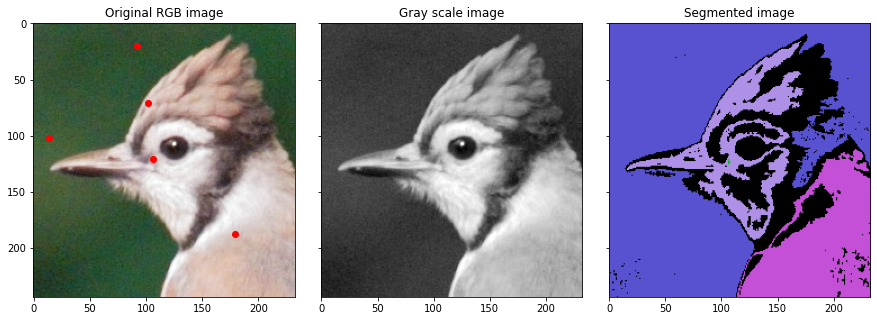

In [15]:
# run region growing algorithm
seg_img = regionGrow(img, seeds, thresh = 0.2, p = 1)

# Show Original and segmented image
fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(img)
axis[0].set_title('Original RGB image')
axis[0].plot(seeds[:, 0], seeds[:, 1], 'ro')

axis[1].imshow(gray_img, 'gray')
axis[1].set_title('Gray scale image')

from utils import colourize

axis[2].imshow(colourize(seg_img))
axis[2].set_title('Segmented image')
plt.show()

### There are two important factors that influence the performance of a region growing algorithm.

1. The first is the seed pixel selection.
    Try the following:
    * Pick a random pixel in the image.
    * Plot the histogram of the image, select a reasonable threshold as you have learned
        in class and then search for a pixel whose intensity value is above the threshold.
    * Do it manually (look for the `matplotlib.pyplot.ginput` function in Python).

Which one is better?

2. The second important factor is how to decide whether to add a neighbouring pixel to the existing region. Again, there are different options. Try the following alternatives:
    * Compare the pixel intensity value of the neighbours to a specified threshold (try the pixel intensity value of the initial seed pixel).
        If it is larger, then add it to the region.
        Depending on the seed pixel you might consider adding pixels with smaller intensities or even using a range of valid intensity values.
    * Compare the pixel intensity value of the neighbours to the average pixel intensity value of the existing region.
        The neighbour with the smallest difference to the average is added to the region.
        How will we stop adding neighbours to the region in this case?

Which one is better?



### More things to try out:
1. What kind of connectivity did you use for considering neighbour pixels? If you used 4- connectivity, try 8-connectivity, if you used 8-connectivity then try 4-connectivity.

    Does this change results?
    
2. What if there are multiple regions of interest? Consider using multiple seed points. How will you choose these?

## Connected Components 

Connected-component labeling (also known as connected-component analysis, or region labeling) is an algorithmic application of graph theory that is used to determine the connectivity of “blob”-like regions in a binary image.

The algorithm process the image in two passes:

**In the first pass**
The algorithm loops over each individual pixel. For each center pixel p, the neighboring pixels are checked

1. Iterate through each element of the data by column, then by row.
2. If the element is not the background
    2. Get the neighboring elements of the current element
    3. If there are no neighbors, uniquely label the current element and continue
    4. Otherwise, find the neighbor with the smallest label and assign it to the current element
Store the equivalence between neighboring labels

**The Second pass**
We start off by looping over the image once again, one pixel at a time.

1. Iterate through each element of the data by column, then by row
2. If the element is not the background
    1. Relabel the element with the lowest equivalent label

Here, the background is a classification, specific to the data, used to distinguish salient elements from the foreground. If the background variable is omitted, then the two-pass algorithm will treat the background as another region.

Make use of `binarize and colourize` helper functions already impelemnted for you in the utils check them to see how to use them.

**Note:** the code make assume PIL (Python Image Library and Imaging package) is already installed.
To install PIL use inside the activate conda env or your working Python env
```
    pip install pillow
```

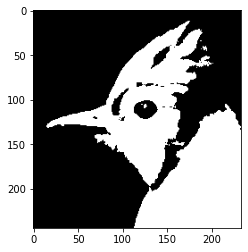

In [16]:
thres_img = gray_img / 255 > 0.5
plt.imshow(thres_img, 'gray')

In [17]:
def ccl4(img, p):
    '''
    Impelemnt region connected components to segment a gray scaled binarized image into regions
    :param img: gray scaled image with size HxW
    :param seed: a list of Points objects contains initial x,y coordinates of the seed pixel
    :param thresh: region growing threshold with default value 0.2
    :param p: select number of neighbors to consider 1 for 8 neighbors and 0 for 4 neighbors [you will need that for next advanced modifications]
    :return: image segmentation of size HxW
    '''
    assert len(img.shape) == 2, f'Wrong input image dimensions, we expected an input of size HxW instead we got {img.shape}'

    labels = np.zeros(img.shape[:2]).astype(int)
    current_label = 1
    visited = np.zeros(img.shape[:2]).astype(bool)
    
    stack = []
    def dfs(x, y):
        nonlocal labels, current_label, img, visited
        h, w = img.shape[:2]
        labels[y, x] = current_label
        neighbours = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]
        if p == 1:
            neighbours += [(x + 1, y + 1), (x - 1, y + 1), (x + 1, y - 1), (x - 1, y - 1)]
        for new_pos in neighbours:
            nx, ny = new_pos
            if 0 <= nx < w and 0 <= ny < h and not visited[ny, nx]:
                if not visited[ny, nx] and img[ny, nx] == 1:
                    visited[ny, nx] = True
                    stack.append(new_pos)
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if not visited[y, x] and img[y, x] == 1:
                visited[y, x] = True
                dfs(x, y)
                while stack:
                    x, y = stack.pop()
                    dfs(x, y)
                current_label += 1

    
    assert labels.shape == img.shape, f'Wrong output image dimensions, we expected to be same size as input {img.shape} instead we got {labels.shape}'
    return labels

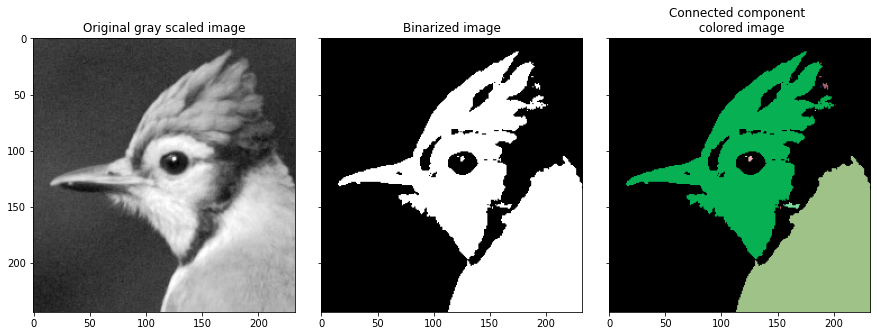

In [18]:
fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(gray_img, 'gray')
axis[0].set_title('Original gray scaled image')

bimg = gray_img / 255 > 0.5

axis[1].imshow(bimg, 'gray')
axis[1].set_title('Binarized image')

from utils import colourize

axis[2].imshow(colourize(ccl4(bimg, 0)))
axis[2].set_title('Connected component \n colored image')
plt.show()

### More things to try out:
1. What kind of connectivity did you use for considering neighbour pixels? If you used 4- connectivity, try 8-connectivity, if you used 8-connectivity then try 4-connectivity.

    Does this change results?
    
2. What if there are multiple regions of interest? Consider using multiple seed points. How will you choose these?